# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp and John Townend at [Victoria University of Wellington---Te Herenga Waka](https://www.wgtn.ac.nz) for use by students entering the postgraduate programme in Earth Science.

We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| [2A](ESCI451_Module_2A.ipynb) | More complex plotting, introduction to Numpy | Geodetic positions; DFDP-2B temperatures |
| [2B](ESCI451_Module_2B.ipynb) | Using Pandas to load, peruse and plot data | Earthquake catalogue  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; earthquake catalogue |
| [3B](ESCI451_Module_3B.ipynb) | Simple time series analysis using Pandas | Historical temperature records |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with Cartopy | Earthquake catalogue |
| **[4B](ESCI451_Module_4B.ipynb)** | **Working with gridded data** | **DEMs and Ashfall data** |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.

# Mapping part 2: working with gridded data

In this notebook we will extend our mapping abilities by plotting some cool data! We are going to do quite a lot of work with gridded data in this notebook, so to start us off we will try plotting a DEM (Digital Elevation Model).

By the end of this notebook you should know how to contour data on maps, and add vectors. We will demonstrate this by making an isopach map and thinking about how wind-direction affects ejecta distribution.

In [23]:
%matplotlib widget

---
## Topography

A common task when working with gridded data is clipping that grid to the region that you are interested in. The main motivation for doing this (rather than working with the whole grid) is to save memory.  Large grids can be very expensive to maintain in memory and even more expensive to plot.

We are going to start by clipping a NZ-wide 80m resolution DEM to the region that you are interested in.  The DEM we will use was downloaded from [koordinates](https://koordinates.com/layer/1418-nz-80m-digital-elevation-model/) and is distributed under a creative commons license (which is also in the data folder). Other DEMs are available - [LINZ has an 8m resolution DEM](https://data.linz.govt.nz/layer/51768-nz-8m-digital-elevation-model-2012/), but it is 17GB...

### Reading the GeoTIFF

The first thing we need to do is load the DEM.  We can also make a quite plot to check that it contains what we expect. The DEM we have is in geotiff format, which is essentially a geo-referenced image format, which is quite common - image files often have great compression, making them useful for sharing gridded data.

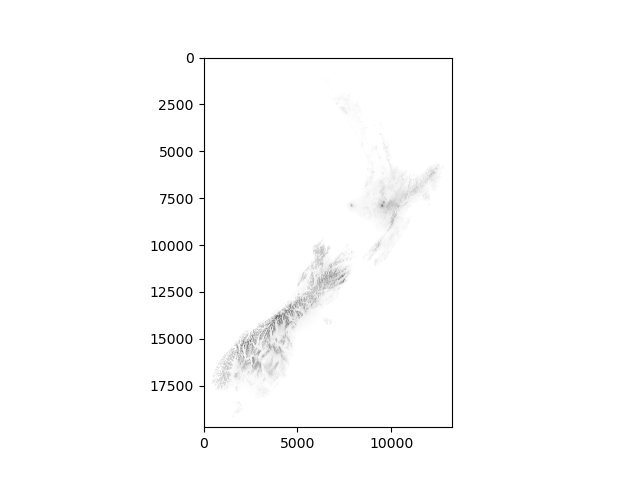

In [24]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("data/nztm.tif") as f:
    dem = f.read(masked=True)

fig, ax = plt.subplots()

# The actual topography in this case is in the zeroth element - tiff's 
# can have multiple dimensions, this one just has 1.
_ = ax.imshow(dem[0], cmap="Greys")

### Clipping to a region

Hopefully you got a plot that looked somewhat like a washed out version of NZ, but it probably took a while to show up! That is because the grid is 19,712 by 13,261 (or 261,400,832) points... Lets make that a bit smaller for our region.

*As a brief aside, if you were plotting the dem for the whole of NZ you probably don't need an 80m resolution and you could downsample the grid using standard numpy slicing.*

We need to define the region we want to clip to and that region needs to be defined in a way that `rasterio` understands - e.g. it needs to be in a real co-ordinate system.  The way to do this is to define a `Shapely` polygon. [Shapely](https://shapely.readthedocs.io/en/stable/index.html) is a really powerful library for working with shapes - if you ever need to work out whether one thing is in another thing, or shear an arbitrary object (maybe a clast?) and work out where the points of that shape would end up, Shapely will help.

I will define a rectanglular polygon, but we could define any shape and we could mask a grid to that shape - you could also use a shape-file and clip to that.

In [25]:
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj

# Set the bounds
min_longitude, max_longitude, min_latitude, max_latitude = 173.8, 175.7, -42.0, -40.7

# Make the Polygon
geom = Polygon([
    (min_longitude, min_latitude), 
    (max_longitude, min_latitude),
    (max_longitude, max_latitude), 
    (min_longitude, max_latitude), 
    (min_longitude, min_latitude)])

# Get the co-ordinate system of the grid
with rasterio.open("data/nztm.tif") as f:
    grid_proj = f"epsg:{f.crs.to_epsg()}"

# Define a transformer
transformer = pyproj.Transformer.from_proj(
    proj_from=pyproj.Proj("epsg:4326"),   # From WGS84 (lat/lon)
    proj_to=grid_proj,           # To the projection of our grid.
    always_xy=True)  # Set to give in longitude, latitude as above

nztm_geom = transform(transformer.transform, geom)
print(nztm_geom)

POLYGON ((1666254.3264171442 5349914.263328397, 1823616.372882802 5346696.852426703, 1828113.381794665 5491038.614971211, 1667585.694441289 5494237.219997164, 1666254.3264171442 5349914.263328397))


Now that we have a shape in the correct co-ordinate system we can use the `mask` module of `rasterio` to mask out the regions we want to exclude.

[[[-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  ...
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]
  [-32768 -32768 -32768 ... -32768 -32768 -32768]]]


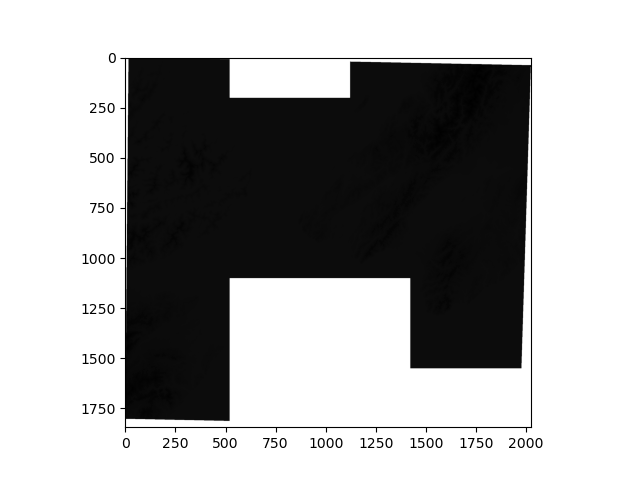

In [26]:
from rasterio.mask import mask

with rasterio.open("data/nztm.tif") as f:
    clipped_dem, clip_transform = mask(f, [nztm_geom], crop=True)
    # Get and maintain the meta-data - we will need it for writing back out
    meta_data = f.meta
    print(clipped_dem)
    
fig, ax = plt.subplots()
_ = ax.imshow(clipped_dem[0], cmap="Greys")

Okay, so that clipped it, but the plot looks rubbish. This is an artefact of all the -32768 values.  These values (in this file) are used to define regions with no-data.  Numpy has a cool [MaskedArray](https://numpy.org/doc/stable/reference/maskedarray.generic.html#constructing-masked-arrays) designed for handling this case (I think it is cool anyway!). Lets make a masked array and re-plot to check that we still have useful data.

The value reserved for no data (NaN) is stored in the metadata by the key "nodata"

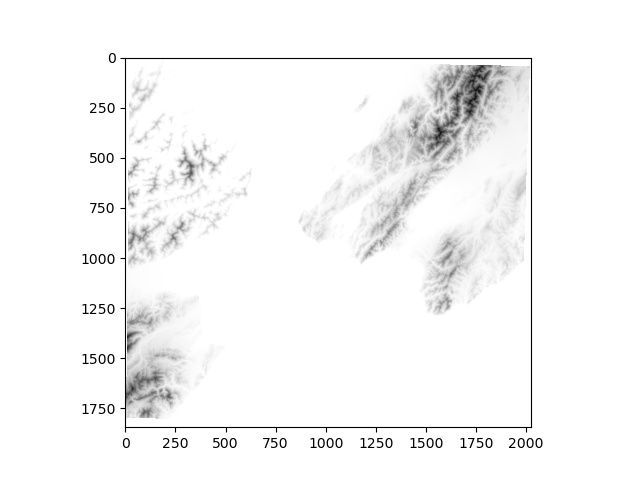

In [27]:
import numpy as np

mask = clipped_dem == meta_data["nodata"]
masked_dem = np.ma.MaskedArray(clipped_dem, mask)

fig, ax = plt.subplots()
_ = ax.imshow(masked_dem[0], cmap="Greys")

Winner! We still have topography!  Now we should write out our clipped grid so that we can stop worrying about working with such large datasets.  

To write back out to geotiff we need to have the dem and the metadata.  The metadata for our clipped grid is the same as our original file, but the origin of the grid has changed. The next cell updates the metadata so that the height and width are the actual size of the DEM and the transform is correct (which defines the origin)

In [28]:
meta_data.update({"driver": "GTiff",
                  "height": clipped_dem.shape[1],
                  "width": clipped_dem.shape[2],
                  "transform": clip_transform})

with rasterio.open("data/clipped_dem.tif", "w", **meta_data) as dest:
    dest.write(clipped_dem)

Quick check to make sure we can read that file...

<open DatasetReader name='data/clipped_dem.tif' mode='r'>


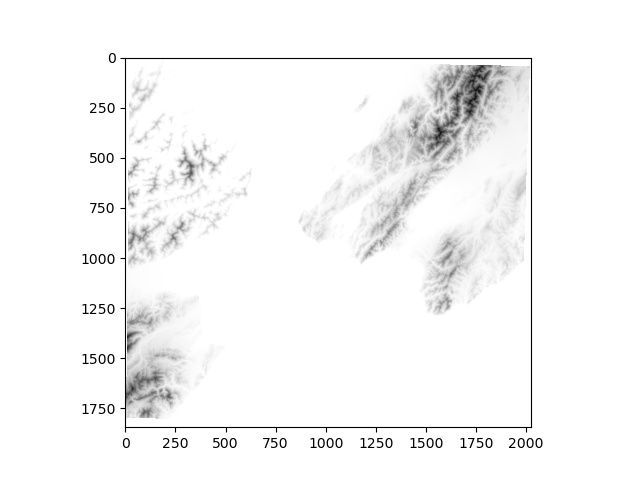

In [29]:
clipped_dem = rasterio.open("data/clipped_dem.tif")
print(clipped_dem)

fig, ax = plt.subplots()
_ = ax.imshow(clipped_dem.read(masked=True)[0], cmap="Greys")
clipped_dem.close()  # Close the open file.

Bonza. I don't know about you, but that seemed tedious. Lets write a quick function so that you can just call the function with a specific lat/lon and write a clipped DEM.  There won't be any new code here, it should just be taking the above and putting into something more useful!

In [30]:
import rasterio
import pyproj

from rasterio.mask import mask


def clip_dem(
    min_longitude: float, 
    max_longitude: float, 
    min_latitude: float, 
    max_latitude: float,
    full_dem_filename: str = "data/nztm.tif",
    clipped_dem_filename: str = "data/clipped_dem.tif",
):
    import os
    import warnings
    from shapely.geometry import Polygon
    from shapely.ops import transform
    # Make the Polygon
    geom = Polygon([
        (min_longitude, min_latitude), 
        (max_longitude, min_latitude),
        (max_longitude, max_latitude), 
        (min_longitude, max_latitude), 
        (min_longitude, min_latitude)])

    # Get the co-ordinate system of the grid
    with rasterio.open(full_dem_filename) as f:
        grid_proj = f"epsg:{f.crs.to_epsg()}"

    # Define a transformer
    transformer = pyproj.Transformer.from_proj(
        proj_from=pyproj.Proj("epsg:4326"),   # From WGS84 (lat/lon)
        proj_to=grid_proj,           # To the projection of our grid.
        always_xy=True)  # Set to give in longitude, latitude as above

    nztm_geom = transform(transformer.transform, geom)
    
    # Clip
    with rasterio.open(full_dem_filename) as f:
        clipped_dem, clip_transform = mask(f, [nztm_geom], crop=True)
        # Get and maintain the meta-data - we will need it for writing back out
        meta_data = f.meta
    
    meta_data.update({"driver": "GTiff",
                      "height": clipped_dem.shape[1],
                      "width": clipped_dem.shape[2],
                      "transform": clip_transform})
    
    # Lets be nice and warn that we are overwriting a file
    if os.path.isfile(clipped_dem_filename):
        warnings.warn(f"Overwriting {clipped_dem_filename} - hope you didn't want that!")
        os.remove(clipped_dem_filename)  # Required on windows

    with rasterio.open(clipped_dem_filename, "w", **meta_data) as dest:
        dest.write(clipped_dem)
    
    return

Great, now lets give that a go for another region to check that it works.

/tmp/ipykernel_32017/4250443557.py:52: UserWarning: Overwriting data/clipped_dem.tif - hope you didn't want that!
  warnings.warn(f"Overwriting {clipped_dem_filename} - hope you didn't want that!")


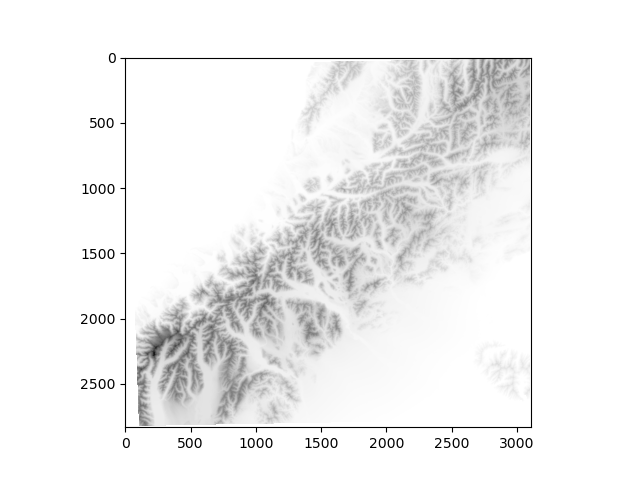

In [31]:
clip_dem(170.0, 173.0, -44.0, -42.0)

with rasterio.open("data/clipped_dem.tif") as f:
    clipped_dem = f.read(masked=True)

fig, ax = plt.subplots()
_ = ax.imshow(clipped_dem[0], cmap="Greys")

Now it is your turn - make a clipped DEM for Fiordland (or anywhere else you care about) and plot it, just like I did above.

In [32]:
# Your map here

---
## Georeferencing the DEM

In all the figures so far we haven't used any real-earth co-ordinate system, which means we can't relate our topography to anything else.  This is where cartopy comes in handy.

To get the DEM to play nicely with cartopy we need to define the grid it is on. The TIFF only tells us the origin and the spacing. From that we need to define a grid in x and y and/or lat/lon.  To do this we are going to make use of the [Xarray](http://xarray.pydata.org/en/stable/) project - this is a great package for dealing with large n-dimensional data. It has a numpy-like interface, but works with much larger data (e.g. data that are larger than memory). We will barely touch its functionality, but it can be really useful for large datasets and/or distributed computing (using multiple computers, or a cluster computer to split up the workload).

To start off we will define the region that we want to work in. I'm going to shift to the Southern Alps because I think they are cool.

In [33]:
# We are going to need some extra packages!

import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from rasterio.warp import transform
import cartopy.feature as cfeature

min_longitude, max_longitude, min_latitude, max_latitude = 170.0, 173.0, -44.0, -42.0

Then I'm going to set the projection for the map. In this case I'm going to use an Albers Equal Area projection. Remember from last time that we need to set some parameters for this projection, and we can do that dynamically based on the region that we want to plot.

In [34]:
map_proj = ccrs.AlbersEqualArea(
    central_latitude=(max_latitude + min_latitude) / 2, 
    central_longitude=(max_longitude + min_longitude) / 2, 
    standard_parallels=[max_latitude, min_latitude])

Then we need to make the clipped DEM for our region. Because the projections between the DEM (NZTM) and our map don't match up I'm going to make the clipped DEM slightly larger than the plotted region to ensure we get topography up to the edges (you can play around with this to see the effect by changing the bounds if you want).

In [35]:
clip_dem(
    min_longitude=min_longitude - .2,
    max_longitude=max_longitude + .2,
    min_latitude=min_latitude - .2,
    max_latitude=max_latitude + .2)

/tmp/ipykernel_32017/4250443557.py:52: UserWarning: Overwriting data/clipped_dem.tif - hope you didn't want that!
  warnings.warn(f"Overwriting {clipped_dem_filename} - hope you didn't want that!")


Now we can open the DEM with xarray and make the X and Y (longitude and latitude) grid that our DEM sits on:

In [36]:
# Open the clipped DEM file
dem = xr.open_rasterio("data/clipped_dem.tif")

# Work out the size of the DEM
ny, nx = len(dem['y']), len(dem['x'])

# Make a grid of nx, ny points
x, y = np.meshgrid(dem['x'], dem['y'])

# Make a transformer to go from the x, y co-ordinate system to latitude and longitude
lon, lat = transform(dem.crs, {'init': 'EPSG:4326'},
    x.flatten(), y.flatten())

# Reshape the arrays back into the grid (this gets lost while transforming)
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))

# Add the longitude and latitude values into the DEM Xarray
dem.coords['lon'] = (('y', 'x'), lon)
dem.coords['lat'] = (('y', 'x'), lat)

/tmp/ipykernel_32017/1560932502.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  dem = xr.open_rasterio("data/clipped_dem.tif")


Great, that is all the setup done, now we can make plots!

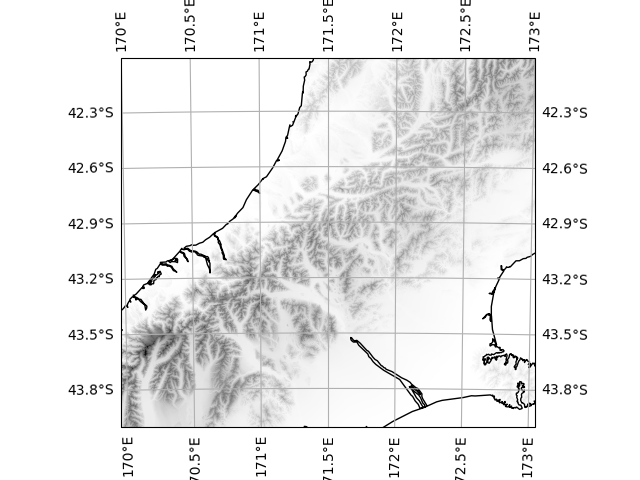

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection=map_proj)
ax.set_extent(
    (min_longitude, max_longitude, min_latitude, max_latitude),
    crs=ccrs.PlateCarree())

# We want to make sure everything without data is masked
dem = dem.where(dem != dem.nodatavals, drop=True)

dem.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(),
               cmap='Greys', add_colorbar=False)
coast = cfeature.GSHHSFeature(
    scale="h", levels=[1], edgecolor="black")
ax.add_feature(coast)

ax.gridlines(draw_labels=True)
_ = ax.set_title("")

Great, now we have a map in real geo-referenced space. Now it is your turn to do some work.

Take what we have shown above and write a function that makes a map with topography, gridlines and a coastline with a given bounding box.  Make it return the figure object so that we can add other things to it if we want.  This kind of function could be the basis for all your future maps!

In [38]:
# your code here.

---
## Working with other gridded data

Now that we can work with topography, how about some cool volcano data?  For this we are going to play around with some model output Simon Barker and colleagues worked up in their paper on [modeling ash dispersal from future eruptions of Taupo supervolcano](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018GC008152).

All the outputs from their models are included in an [online repository](https://www.sciencebase.gov/catalog/item/5cdd9ed7e4b029273746367a), as any good, modern paper should! I have taken the liberty of including one model output in the data directory and we will start by playing with that, but you should explore the data repository and get other model outputs if you want.

The output of the model is ash thickness, and is modeled dependent on a few things, including wind direction.

To start off we need to read the data.  The data provided is in an Earth referenced ASCII format. Xarray is our friend here again! Yay!

<xarray.DataArray (band: 1, y: 60, x: 120)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -32.62 -32.88 -33.12 -33.38 ... -46.88 -47.12 -47.38
  * x        (x) float64 160.1 160.4 160.6 160.9 ... 189.1 189.4 189.6 189.9
Attributes:
    transform:   (0.25, 0.0, 160.0, 0.0, -0.25, -32.5)
    res:         (0.25, 0.25)
    is_tiled:    0
    nodatavals:  (0.0,)
    scales:      (1.0,)
    offsets:     (0.0,)


/tmp/ipykernel_32017/2538917993.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  deposit_model = xr.open_rasterio(datafile)


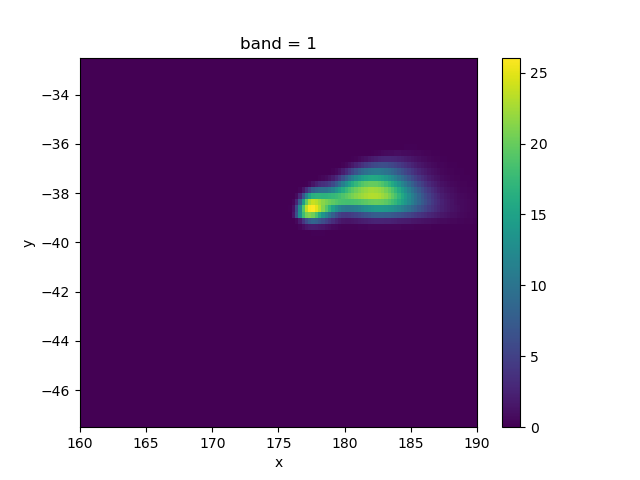

In [39]:
datafile = "data/DepositFile_ESRI_ASCII.txt"

deposit_model = xr.open_rasterio(datafile)
print(deposit_model)
fig, ax = plt.subplots()
_ = deposit_model.plot(ax=ax)

Sweet, that was easy! Lets work up a nicer plot using cartopy again.

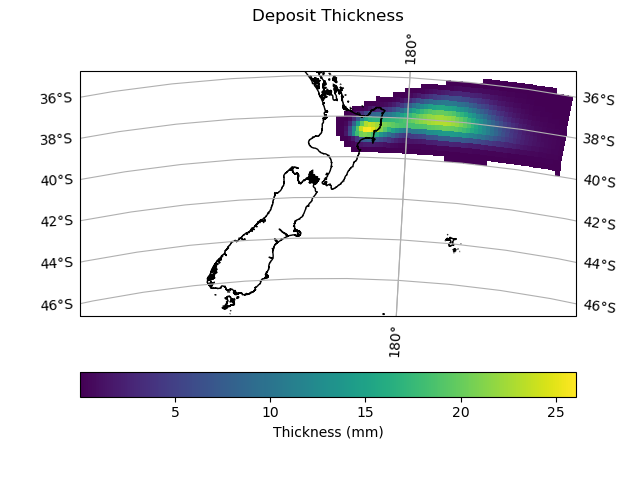

In [40]:
min_longitude, max_longitude, min_latitude, max_latitude = 160, 190, -47, -35

map_proj = ccrs.AlbersEqualArea(
    central_latitude=(max_latitude + min_latitude) / 2, 
    central_longitude=(max_longitude + min_longitude) / 2, 
    standard_parallels=[max_latitude, min_latitude])

fig = plt.figure()
ax = fig.add_subplot(projection=map_proj)
ax.set_extent(
    (min_longitude, max_longitude, min_latitude, max_latitude),
    crs=ccrs.PlateCarree())

deposit_model = deposit_model.where(deposit_model != deposit_model.nodatavals, drop=True)

# Note that we can add a colorbar here and control the label and other properties of it using the cbar_kw
deposit_model.plot(
    ax=ax, x='x', y='y', transform=ccrs.PlateCarree(),
    cmap='viridis', add_colorbar=True, 
    cbar_kwargs={"label": "Thickness (mm)", "orientation": "horizontal"})


coast = cfeature.GSHHSFeature(
    scale="h", levels=[1], edgecolor="black")
ax.add_feature(coast)

ax.gridlines(draw_labels=True)
_ = ax.set_title("Deposit Thickness")

If you try changing the projection to `PlateCarree()` you will see some odd and annoying effects - plotting across the dateline is a little tricky and you do have to set the `central_longitude` argument to 180 (the default is 0).

That is fairly cool -guess the wind direction during this simulated eruption!

Now it is your turn.

Go and grab a different simulation (the one above is the first simulation output) from the [data repository](https://www.sciencebase.gov/catalog/item/5cdd9ed7e4b029273746367a) and try plotting it.

In [41]:
# Your turn!

---
## Contouring gridded map data

Matplotlib has a [contour function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html#matplotlib.pyplot.contour) that allows us to fairly simply plot contours around gridded data.

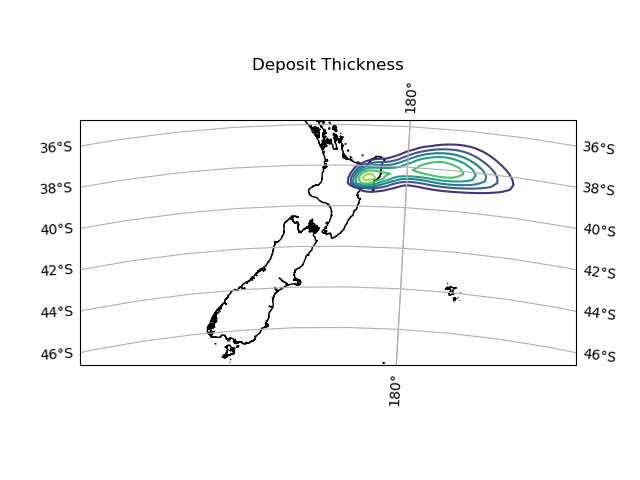

In [42]:
fig = plt.figure()
ax = fig.add_subplot(projection=map_proj)
ax.set_extent(
    (min_longitude, max_longitude, min_latitude, max_latitude),
    crs=ccrs.PlateCarree())

ax.contour(deposit_model.x, deposit_model.y, deposit_model[0], transform=ccrs.PlateCarree())

coast = cfeature.GSHHSFeature(
    scale="h", levels=[1], edgecolor="black")
ax.add_feature(coast)

ax.gridlines(draw_labels=True)
_ = ax.set_title("Deposit Thickness")

That is kinda cool, but some labels on those contours would be good!

I'm going to zoom in to a smaller region to be able to see the contour labels better, and add contour labels using the [clabel](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.clabel.html) method.

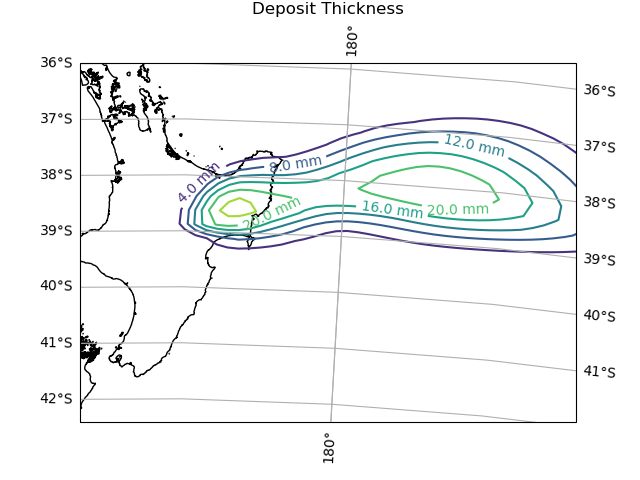

In [43]:
fig = plt.figure()
ax = fig.add_subplot(projection=map_proj)
ax.set_extent(
    (174, 185, -42, -36),
    crs=ccrs.PlateCarree())

contours = ax.contour(deposit_model.x, deposit_model.y, deposit_model[0], transform=ccrs.PlateCarree())
ax.clabel(contours, fmt="%.1f mm")  # Define format to 1 decimal place with trailing mm unit.

coast = cfeature.GSHHSFeature(
    scale="h", levels=[1], edgecolor="black")
ax.add_feature(coast)

ax.gridlines(draw_labels=True)
_ = ax.set_title("Deposit Thickness")

That is it for me. Your final task is you chose to accept it is to make a map with topography and contours of deposit thickness for a model run of your choosing. 

Good luck!

In [44]:
# Your code here.

---
## Beyond Cartopy

Cartopy and friends are pretty cool, but not this isn't by any means the only way to plot geospatial data. Below are a list of other projects you might want to check out:

- [GMT](https://www.generic-mapping-tools.org/) remains the standard mapping interface for most geophysics and geology publications, and makes really pretty plots. [pyGMT](https://www.pygmt.org/latest/) (GMT for Python) is coming, but developing the interfaces takes quite a while - for most of us writing code isn't our main job, so developing has to fit around the other things that we are paid to do (teach, do research, write proposals, moan about management etc.)
- [bokeh](https://bokeh.org/) is pretty cool for creating interactive plots, including [maps](https://docs.bokeh.org/en/latest/docs/user_guide/geo.html) - CJC uses this quite a bit for interogating data.
- [follium](https://github.com/python-visualization/folium) looks nice for making interactive mapping plots - possibly better than bokeh because it is more focused on mapping.

That is all for now - hopefully that has given you some idea of how you can make some fairly nice plots without too much effort.  A key idea with these notebooks is for you to **borrow some code** from them so that you do not have to re-write everything yourself.